# Maxime BACQUET et Mathieu CARON

# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [2]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt

**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

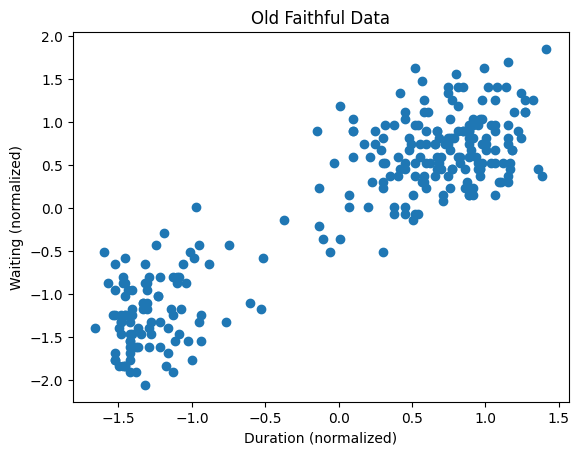

In [3]:
# Load the "Old Faithful" dataset from the Seaborn library
df = seaborn.load_dataset('geyser')
X = df[['duration', 'waiting']].values
N, D = X.shape

# Standardize data to avoid numerical instabilities
# Calcul moyenne / écart-type pour chaque feature
mean_X = X.mean(axis=0) 
std_X = X.std(axis=0)
# Normalisation des données
X = (X - mean_X) / std_X 

# Show data
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Duration (normalized)')
plt.ylabel('Waiting (normalized)')
plt.title('Old Faithful Data')

# J'enregistre la figure sous forme de fichier img
plt.savefig('img/old_faithful_data.png', dpi=300, bbox_inches='tight')

plt.show()


On peut voir deux clusters qui pourraient être modélisés à l'aide d'un modèle de mélange gaussien








**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_k}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k, \pi_1, ..., \pi_k \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [4]:
from scipy.stats import multivariate_normal

def log_likelihood(X, pi, mu, sigma): 
    """
    Calcule la log-vraisemblance

    Args:
        X (array): Les données, chaque ligne représente une observation.
        pi (array): Les poids des composantes.
        mu (list): Une liste contenant les vecteurs moyens de chaque composante.
        sigma (list): Une liste contenant les matrices de covariance de chaque composante.

    Returns:
        float: La log-vraisemblance du modèle.
    """
    n, D = X.shape
    K = len(pi)
    log_likelihood_value = 0.0

    # Calcul de la première somme sur i
    for i in range(n):
        # Calcul de la seconde somme sur k
        likelihood_i = 0.0
        for k in range(K):
            likelihood_i += pi[k] * multivariate_normal.pdf(X[i], mean=mu[k], cov=sigma[k])

        log_likelihood_value += np.log(likelihood_i)

    return log_likelihood_value

**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [5]:
def EM_algorithm_v1(X, K, Niter):
    N, D = X. shape
    
    # Initialize parameters

    # Initialisation de mu (K premières observations du dataset)
    mu = X[:K, :].copy()
    # Initialisation de sigma (matrice identité)
    sigma = [np.eye(D) for _ in range(K)]
    # Initialisation de pi (1/K)
    pi = np.ones(K) / K

    # On initialise un tableau vide pour récupérer les log_vraisemblance
    log_likelihood_values = []

    # On boucle sur le nombre d'itération
    for i in range(0,Niter):
        # E-STEP
        
        # On initialise notre valeur gamma qui va correspondre à la probabilité de chaque échantillon et chaque composante
        gamma = np.zeros((N, K))

        # On calcul ces probabilités
        for n in range(N):
            for k in range(K):
                gamma[n, k] = pi[k] * multivariate_normal.pdf(X[n], mean=mu[k], cov=sigma[k])
            gamma[n, :] /= np.sum(gamma[n, :])        
        
        # M-STEP

        # Calcul du nombre d'observations affectées à chaque composante
        Nk = np.sum(gamma, axis=0)

        # Mise à jour de mu 
        # Initialisation de mu_new  
        mu_new = np.zeros_like(mu)
        # Calcul des nouveaux mu
        for k in range(K):
            for n in range(N):
                mu_new[k] += gamma[n, k] * X[n]
            mu_new[k] /= Nk[k]
        # Mise à jour des mu
        mu = mu_new

        # Mise à jour de simga
        # Initialisation de sigma_new
        sigma_new = []
        # Calcul des nouveaux sigma
        for k in range(K):
            sigma_k = np.zeros((D, D))
            for n in range(N):
                sigma_k += gamma[n, k] * np.outer(X[n], X[n].T)
            sigma_k_new = sigma_k / Nk[k]
            sigma_k_new = sigma_k_new - np.outer(mu[k], mu[k].T)
            sigma_new.append(sigma_k_new)
        # Mise à jour des sigma
        sigma = sigma_new

        # Mise à jour des pi
        pi = Nk / N

        # Calcul de la log-vraisemblance
        log_likelihood_value = log_likelihood(X, pi, mu, sigma)
        log_likelihood_values.append(log_likelihood_value)
        
    return log_likelihood_values, pi, mu, sigma

**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

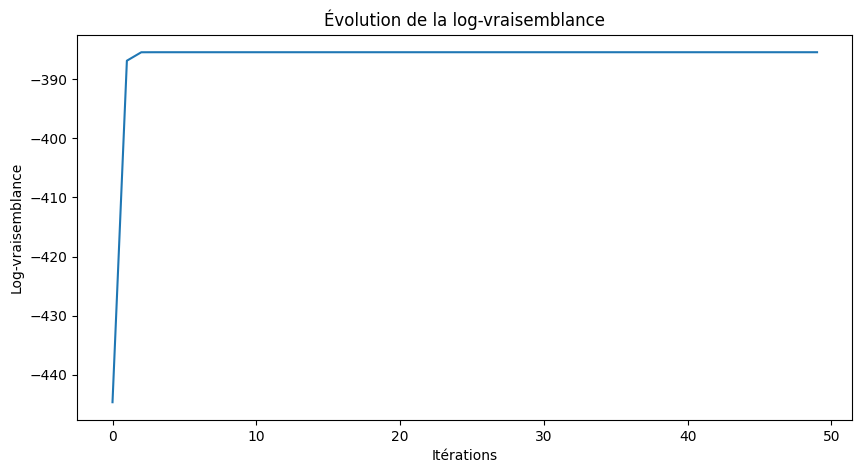

In [6]:
K = 2
Niter = 50

log_likelihood_values, pi, mu, sigma = EM_algorithm_v1(X, K, Niter)

# Affichage de l'évolution de la log-vraisemblance
plt.figure(figsize=(10, 5))
plt.plot(range(Niter), log_likelihood_values)
plt.title('Évolution de la log-vraisemblance')
plt.xlabel('Itérations')
plt.ylabel('Log-vraisemblance')

# J'enregistre la figure sous forme de fichier img
plt.savefig('img/log_likelihood_evolution.png', dpi=300, bbox_inches='tight')

plt.show()


Le graphique de l'évolution de la log-vraisemblance montre une croissance rapide au début de l'algorithme. Ceci montre qu'il y a des améliorations significatives dans l'ajustement du modèle. Cependant, cette croissance ralentit après quelques itérations (4/5), indiquant que les ajustements deviennent moins importants.

=> Cela indique donc que l'algorithme EM trouve rapidement une meilleure explication pour les données en ajustant les paramètres du modèle.

Maintenant nous allons afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*.

C:\Users\mathc\AppData\Local\Temp\ipykernel_2340\1480720770.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z1, levels=[0.01], colors='red', linestyles='dashed', label='Estimation loi 1')
C:\Users\mathc\AppData\Local\Temp\ipykernel_2340\1480720770.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z2, levels=[0.01], colors='blue', linestyles='dashed', label='Estimation loi 2')


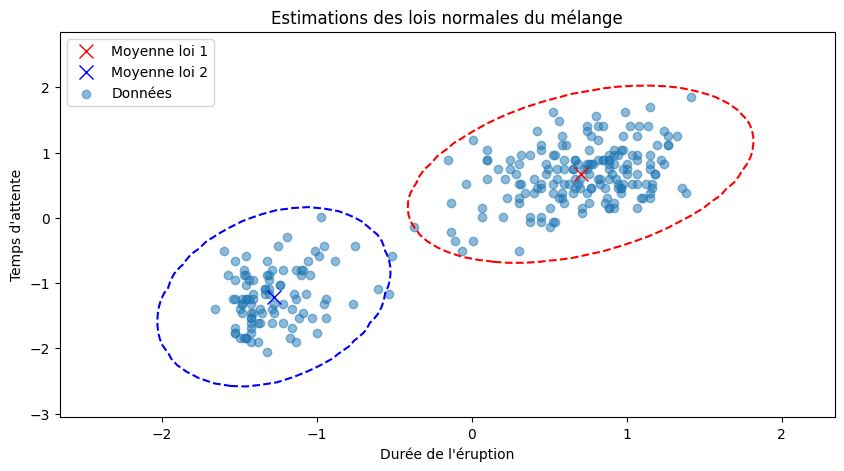

In [7]:
# On crée une grille de coordonnées
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# On calcule les estimations des lois normales sur la grille
Z1 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu[0], cov=sigma[0])
Z1 = Z1.reshape(xx.shape)
Z2 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu[1], cov=sigma[1])
Z2 = Z2.reshape(xx.shape)

# On peut donc afficher le dataset et les estimations
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Données')
plt.contour(xx, yy, Z1, levels=[0.01], colors='red', linestyles='dashed', label='Estimation loi 1')
plt.contour(xx, yy, Z2, levels=[0.01], colors='blue', linestyles='dashed', label='Estimation loi 2')

# On affiche aussi les moyennes des lois avec des croix
plt.plot(mu[0, 0], mu[0, 1], 'rx', markersize=10, label='Moyenne loi 1')
plt.plot(mu[1, 0], mu[1, 1], 'bx', markersize=10, label='Moyenne loi 2')

plt.title('Estimations des lois normales du mélange')
plt.xlabel('Durée de l\'éruption')
plt.ylabel('Temps d\'attente')
plt.legend()

# J'enregistre la figure sous forme de fichier img
plt.savefig('img/lois_normales_melange.png', dpi=300, bbox_inches='tight')

plt.show()


L'observation montre que les deux lois parviennent à englober distinctement les deux clusters initiaux, chacune ayant sa moyenne positionnée au centre de son regroupement respectif.

**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [8]:
def EM_algorithm_v2(X, K, Niter, seed):
    N, D = X. shape
    
    # Initialize parameters
    np.random.seed(seed)

    # Initialisation de mu selon la distribution normale
    mu = np.random.multivariate_normal(np.zeros(D), np.eye(D), size=K)
    # Initialisation de sigma (matrice identité)
    sigma = [np.eye(D) for _ in range(K)]
    # Initialisation de pi selon la distribution Dirichlet
    pi = np.random.dirichlet(np.ones(K))

    # Ensuite on peut reprendre la même implémentation que dans EM_algorithm_v1

    # On initialise un tableau vide pour récupérer les log_vraisemblance
    log_likelihood_values = []

    # On boucle sur le nombre d'itération
    for i in range(0,Niter):
        # E-STEP
        
        # On initialise notre valeur gamma qui va correspondre à la probabilité de chaque échantillon et chaque composante
        gamma = np.zeros((N, K))

        # On calcul ces probabilités
        for n in range(N):
            for k in range(K):
                gamma[n, k] = pi[k] * multivariate_normal.pdf(X[n], mean=mu[k], cov=sigma[k])
            gamma[n, :] /= np.sum(gamma[n, :])        
        
        # M-STEP

        # Calcul du nombre d'observations affectées à chaque composante
        Nk = np.sum(gamma, axis=0)

        # Mise à jour de mu 
        # Initialisation de mu_new  
        mu_new = np.zeros_like(mu)
        # Calcul des nouveaux mu
        for k in range(K):
            for n in range(N):
                mu_new[k] += gamma[n, k] * X[n]
            mu_new[k] /= Nk[k]
        # Mise à jour des mu
        mu = mu_new

        # Mise à jour de simga
        # Initialisation de sigma_new
        sigma_new = []
        # Calcul des nouveaux sigma
        for k in range(K):
            sigma_k = np.zeros((D, D))
            for n in range(N):
                sigma_k += gamma[n, k] * np.outer(X[n], X[n].T)
            sigma_k_new = sigma_k / Nk[k]
            sigma_k_new = sigma_k_new - np.outer(mu[k], mu[k].T)
            sigma_new.append(sigma_k_new)
        # Mise à jour des sigma
        sigma = sigma_new

        # Mise à jour des pi
        pi = Nk / N

        # Calcul de la log-vraisemblance
        log_likelihood_value = log_likelihood(X, pi, mu, sigma)
        log_likelihood_values.append(log_likelihood_value)
        
    return log_likelihood_values, pi, mu, sigma

**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

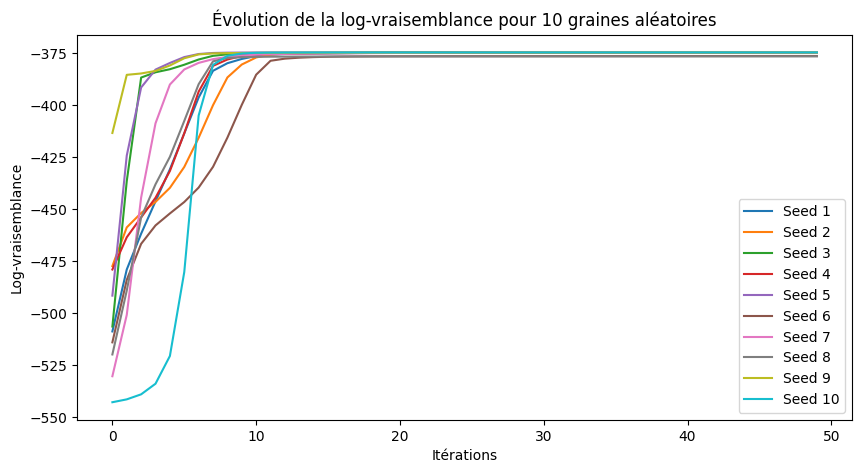

In [9]:
K = 3
Niter = 50

# On va stocker les valeurs des log-vraisemblance pour nos 10 cas dans une liste
log_likelihood_values_list = []

# On utilise notre fonction pour 10 graines aléatoires différentes
for seed in range(10):
    log_likelihood_values, _, _, _ = EM_algorithm_v2(X, K, Niter, seed)
    log_likelihood_values_list.append(log_likelihood_values)

# On trace l'évolution de la log-vraisemblance pour les 10 graines aléatoires
plt.figure(figsize=(10, 5))
for i, log_likelihood_values in enumerate(log_likelihood_values_list):
    plt.plot(range(Niter), log_likelihood_values, label=f'Seed {i+1}')
plt.title('Évolution de la log-vraisemblance pour 10 graines aléatoires')
plt.xlabel('Itérations')
plt.ylabel('Log-vraisemblance')
plt.legend()

# J'enregistre la figure sous forme de fichier img
plt.savefig('img/evolution-log-vraisemblance-10-graines-aleatoires.png', dpi=300, bbox_inches='tight')

plt.show()

On peut voir que l'évolution de la log-vraisemblance en fonction des itérations dépend de l'initialisation aléatoire des paramètres. Cependant, on observe aussi que la log-vraisemblance augmente au fil des itérations, car l'algorithme EM cherche à maximiser la vraisemblance du modèle quelque soit nos paramètres d'initialisation.

C:\Users\mathc\AppData\Local\Temp\ipykernel_2340\1509364809.py:40: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z1_seed1, levels=[0.01], colors='red', linestyles='dashed', label='Estimation loi 1')
C:\Users\mathc\AppData\Local\Temp\ipykernel_2340\1509364809.py:41: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z2_seed1, levels=[0.01], colors='blue', linestyles='dashed', label='Estimation loi 2')
C:\Users\mathc\AppData\Local\Temp\ipykernel_2340\1509364809.py:42: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z3_seed1, levels=[0.01], colors='orange', linestyles='dashed', label='Estimation loi 3')
C:\Users\mathc\AppData\Local\Temp\ipykernel_2340\1509364809.py:57: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z1_seed2, levels=[0.01], colors='red', linestyles='dashed', label='Estimation loi 1')
C:\Users\mathc\AppData\L

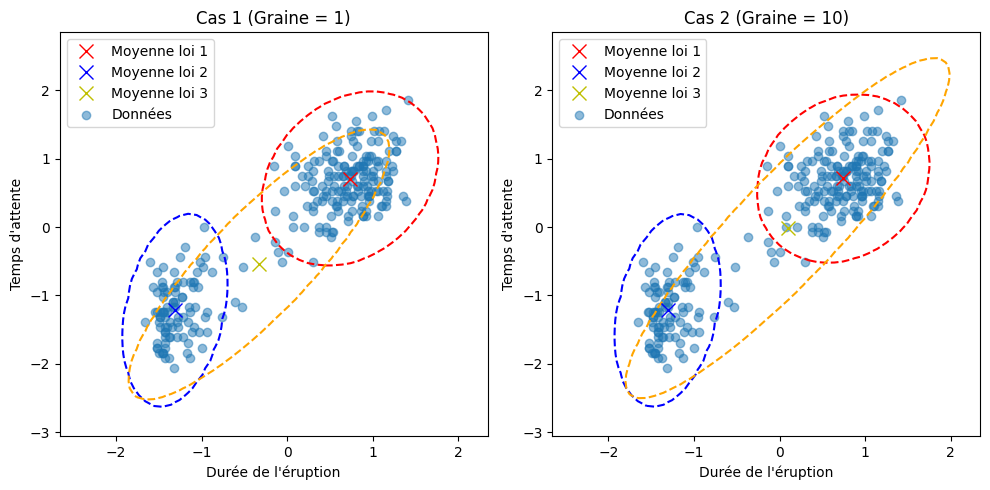

In [10]:
# Deux cas visuellement différents

# On choisit la seed 9 et 10
seed1 = 1
seed2 = 10

_, pi1, mu1, sigma1 = EM_algorithm_v2(X, K, Niter, seed1)
_, pi2, mu2, sigma2 = EM_algorithm_v2(X, K, Niter, seed2)

# Afiichage 

# On crée une grille de coordonnées
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# On calcule les estimations des lois normales sur la grille pour seed1
Z1_seed1 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu1[0], cov=sigma1[0])
Z1_seed1 = Z1_seed1.reshape(xx.shape)
Z2_seed1 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu1[1], cov=sigma1[1])
Z2_seed1 = Z2_seed1.reshape(xx.shape)
Z3_seed1 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu1[2], cov=sigma1[2])
Z3_seed1 = Z3_seed1.reshape(xx.shape)

# On calcule les estimations des lois normales sur la grille pour seed2
Z1_seed2 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu2[0], cov=sigma2[0])
Z1_seed2 = Z1_seed2.reshape(xx.shape)
Z2_seed2 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu2[1], cov=sigma2[1])
Z2_seed2 = Z2_seed2.reshape(xx.shape)
Z3_seed2 = multivariate_normal.pdf(np.column_stack((xx.ravel(), yy.ravel())), mean=mu2[2], cov=sigma2[2])
Z3_seed2 = Z3_seed2.reshape(xx.shape)

# Tracer le dataset et les estimations des lois normales du mélange pour les deux cas
plt.figure(figsize=(10, 5))

# Cas 1
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Données')
plt.contour(xx, yy, Z1_seed1, levels=[0.01], colors='red', linestyles='dashed', label='Estimation loi 1')
plt.contour(xx, yy, Z2_seed1, levels=[0.01], colors='blue', linestyles='dashed', label='Estimation loi 2')
plt.contour(xx, yy, Z3_seed1, levels=[0.01], colors='orange', linestyles='dashed', label='Estimation loi 3')

# On affiche aussi les moyennes des lois avec des croix
plt.plot(mu1[0, 0], mu1[0, 1], 'rx', markersize=10, label='Moyenne loi 1')
plt.plot(mu1[1, 0], mu1[1, 1], 'bx', markersize=10, label='Moyenne loi 2')
plt.plot(mu1[2, 0], mu1[2, 1], 'yx', markersize=10, label='Moyenne loi 3')

plt.title(f'Cas 1 (Graine = {seed1})')
plt.xlabel('Durée de l\'éruption')
plt.ylabel('Temps d\'attente')
plt.legend()

# Cas 2
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Données')
plt.contour(xx, yy, Z1_seed2, levels=[0.01], colors='red', linestyles='dashed', label='Estimation loi 1')
plt.contour(xx, yy, Z2_seed2, levels=[0.01], colors='blue', linestyles='dashed', label='Estimation loi 2')
plt.contour(xx, yy, Z3_seed2, levels=[0.01], colors='orange', linestyles='dashed', label='Estimation loi 3')

# On affiche aussi les moyennes des lois avec des croix
plt.plot(mu2[0, 0], mu2[0, 1], 'rx', markersize=10, label='Moyenne loi 1')
plt.plot(mu2[1, 0], mu2[1, 1], 'bx', markersize=10, label='Moyenne loi 2')
plt.plot(mu2[2, 0], mu2[2, 1], 'yx', markersize=10, label='Moyenne loi 3')

plt.title(f'Cas 2 (Graine = {seed2})')
plt.xlabel('Durée de l\'éruption')
plt.ylabel('Temps d\'attente')
plt.legend()

plt.tight_layout()
plt.show()

Le choix de différentes graines aléatoires permet d'explorer diverses initialisations possibles et d'évaluer la stabilité des solutions. En observant les résultats de différentes initialisations, on peut mieux comprendre la sensibilité de l'algorithme aux conditions initiales. Cela permet également de s'assurer que la solution obtenue n'est pas un optimum local mais bien le maximum global de la vraisemblance.

Quelle estimation de paramètres doit-on choisir ?

Idéalement, on devrait choisir l'estimation de paramètres qui maximise la log-vraisemblance. Cependant, cela peut être délicat car l'algorithme EM peut parfois converger vers des optima locaux. Il est donc recommandé de répéter l'algorithme EM avec différentes initialisations et de choisir celle qui donne la log-vraisemblance la plus élevée. On peut également utiliser des techniques d'optimisation plus avancées pour améliorer la recherche des paramètres optimaux.

En résumé, il est crucial de prendre en compte la stabilité des résultats et d'évaluer la robustesse de l'algorithme EM en choisissant les paramètres qui maximisent la log-vraisemblance sur plusieurs initialisations.

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance de le modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

In [14]:
# Définir les valeurs de K et D
K_values = np.arange(1, 7)
D = 2  # Comme spécifié dans le TP

# Calculer k(m) pour chaque valeur de K
k_values = (K_values / 2) * (D + 1) * (D + 2) - 1

# Calculer le BIC pour chaque modèle
BIC_values = []

# Remplacer cette boucle par le calcul de la log-vraisemblance pour chaque modèle
for k in k_values:

    # On va stocker les valeurs des log-vraisemblance pour nos 10 cas dans une liste
    log_likelihood_values_list = []

    # On utilise notre fonction pour 10 graines aléatoires différentes
    for seed in range(10):
        log_likelihood_values, _, _, _ = EM_algorithm_v2(X, K, Niter, seed)
        log_likelihood_values_list.append(log_likelihood_values)    
    
    # Calculer la log-vraisemblance pour le modèle avec k paramètres
    log_likelihood_m = log_likelihood_values_list[-1]  # On prend la dernière valeur de log-vraisemblance
    BIC_m = k * np.log(N) - 2 * log_likelihood_m
    BIC_values.append(BIC_m)

# Trouver le modèle optimal
optimal_model_index = np.argmin(BIC_values)
optimal_K = K_values[optimal_model_index]

print(f"Le modèle optimal selon le critère BIC est celui avec K = {optimal_K}.")



----- Votre réponse ici -----

**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.


----- Votre réponse ici -----